INFO     [covid19_npis.data] Loaded data for Germany.
INFO     [covid19_npis.data] Loaded data for Finland.


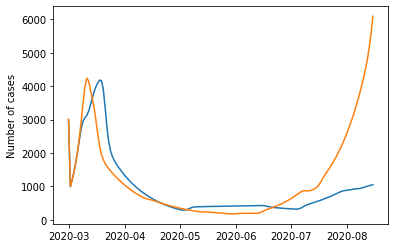

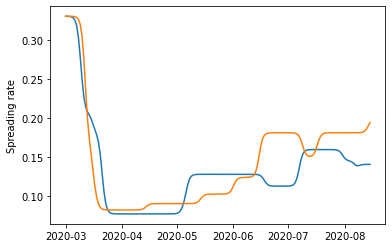

In [1]:
import sys
import logging
import time
import itertools
import os
import datetime
import functools

from tqdm import tqdm
import pandas as pd
import pymc4 as pm
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

sys.path.append("../../")
import covid19_npis
from covid19_npis.model import *


# Load data, it uses only the intervention data (when and which interventions were implemented)
# saved in interventions.csv in the respective country folder
# The length of the modelling is defined by the length of the files inside the country folders, 
# currently they are from the 2.3.2020 until the 15.8.2020
countries = [
    "Germany",
    "Finland",
]
c = [
    covid19_npis.data.Country(f"../../data/coverage_db/{country}",)
    for country in countries
]

# Construct our modelParams from the data.
modelParams = covid19_npis.ModelParams(countries=c, minimal_daily_deaths=1, offset_sim_data=1)

# Prepare modelParams such that there is only one age_group left
df = modelParams.pos_tests_dataframe.sum(axis=1, level='country')
df.columns = pd.MultiIndex.from_product([df.columns, ['age_group_0']]).set_names("age_group", level=1)
modelParams._dataframe_new_cases = df
modelParams._update_data_summary()
modelParams.pos_tests_data_tensor = df


# Define the model
@pm.model()
def SIR_model(modelParams):
    lambda_0 = yield construct_lambda_0(
        name="lambda_0_c",
        modelParams=modelParams,
        loc=0.4,
        scale=0.1,
        hn_scale=0.05,  # Scale parameter of HalfNormal for each country
    )
    lambda_t = yield construct_R_t(
        name="lambda_t", modelParams=modelParams, R_0=lambda_0, include_noise = False
    )
    
    
    I_0_estimate = tf.reduce_mean(modelParams.pos_tests_data_tensor[1:6], axis=0)/(lambda_0+0.01)
    I_0 = (yield Normal(
        name="I_0_raw",
        loc = 0,
        scale=1,
        conditionally_independent=True,
        event_stack=(modelParams.num_countries, modelParams.num_age_groups),
    ))*I_0_estimate/6 + I_0_estimate
    I_0 = tf.math.softplus(I_0)
    
    I_0 = yield Deterministic(
        name="I_0", value=I_0, shape_label=("country", "age_group"),
    )
        

    C = tf.ones([1,1])
    log.debug(f"C:\n{C.shape}")
    log.debug(f"C:\n{C}")
    N = modelParams.N_data_tensor
    log.debug(f"N:\n{N}")
    new_I_t = InfectionModel_SIR(
        N=N,  I_0=I_0, lambda_t=lambda_t, C=C  
    )
    log.debug(f"new_I_t:\n{new_I_t[0,:]}")  # dimensons=t,c,a
    
    # Assume infections are positive tests
    positive_tests = yield Deterministic(
        name="positive_tests", value=new_I_t, shape_label=("time", "country", "age_group"),
    )
    
    
    yield covid19_npis.model.likelihood._studentT_positive_tests(modelParams, pos_tests=positive_tests)
    

# Define parameters for the test data set 
# These are defined not on the highest level, the sampling occurs on an unbounded space and
# some variables (for example alpha_i_c_a) depend on previous hierarchical variables. This allows
# to not define too many variables and nevertheless still get a test dataset.
params = {
    # population size per country and age group
    "N": np.array([[1e15], [1e15]]),
    # Reproduction number at t=0 per country and age group
    "lambda_0_c": np.array([0.33, 0.33]),
    # Initial infected
    "I_0": 3000 * np.array([[1], [1]]),
    # Change point date/index
    "delta_d_i": np.zeros((modelParams.num_interventions, 1, 1)),
    "delta_d_c": np.zeros((1, modelParams.num_countries, 1)),
    "sigma_d_interv": 0.3,
    "sigma_d_country": 0.3,
    # Length of the change point
    "l_i_sign": 4 * np.ones((modelParams.num_interventions,)),
    # Alpha value of the change point
    "alpha_i_c_a": np.stack(
        [[[0.38], [0.38]]]
        * modelParams.num_interventions
    )
    * 1,
    "C": np.stack(
        np.array(
            [
                [
                    [1],
                ]
            ]
            * 2
        )
    ),
}

# Create the test data
(
    positive_tests,
    lambda_t,
), trace = covid19_npis.test_data.data_generators.test_data_from_model(
    SIR_model,
    modelParams,
    params,
    [
        "positive_tests",
        "lambda_t",]
)


# Plot the data set for the test. 
# The first point is the total infection pool and not the new infections, that's why it is larger than the rest
plt.plot(positive_tests)
plt.ylabel("Number of cases")
plt.figure()
plt.plot(lambda_t)
plt.ylabel("Spreading rate")

# Set the test data set 
modelParams._dataframe_new_cases = positive_tests[1:] 
modelParams.pos_tests_data_tensor = positive_tests[1:]
this_model = SIR_model(modelParams) 





INFO     [covid19_npis.model.distributions] start
Auto-assigning NUTS sampler
INFO     [pymc4.sampling] Auto-assigning NUTS sampler


init state:
SIR_model|__SoftPlus_sigma_likelihood_pos_tests
[4.3029194 1.2766986] 
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


WARNING  [tensorflow] From /home/jdehning/miniconda3/envs/test-env2/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:5039: calling gather (from tensorflow.python.ops.array_ops) with validate_indices is deprecated and will be removed in a future version.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
INFO     [pymc4.inference.sampling] Begin tuning
tuning windows: [ 500  750 1150 1700 2550 3800 5700]
INFO     [pymc4.sampling] tuning windows: [ 500  750 1150 1700 2550 3800 5700]
log-like: -1151.5: 100%|██████████| 16150/16150 [05:12<00:00, 51.76it/s]
INFO     [pymc4.inference.sampling] Begin sampling
log-like: -1147.6: 100%|██████████| 1000/1000 [00:22<00:00, 44.66it/s]
INFO     [covid19_npis.model.distributions] running time: 403.2s


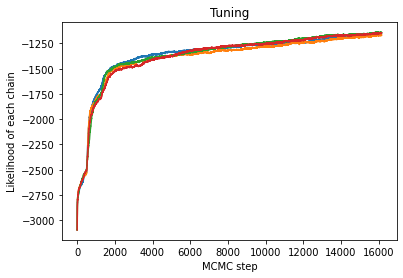

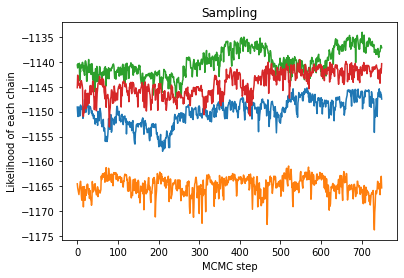

In [2]:
# Some checks
def print_dist_shapes(st):
    for name, dist in itertools.chain(
        st.discrete_distributions.items(), st.continuous_distributions.items(),
    ):
        if dist.log_prob(st.all_values[name]).shape != (5,):
            log.warning(
                f"False shape: {dist.log_prob(st.all_values[name]).shape}, {name}"
            )
    for p in st.potentials:
        if p.value.shape != (5,):
            log.warning(f"False shape: {p.value.shape} {p.name}")


_, sample_state = pm.evaluate_model_transformed(this_model, sample_shape=(5,))
print_dist_shapes(sample_state)


# Begin sampling
begin_time = time.time()
log.info("start")

num_chains = 4

trace_tuning, trace = pm.sample(
    this_model,
    num_samples=3000,
    num_samples_binning=50,
    burn_in_min=500,
    burn_in=15000,
    use_auto_batching=False,
    num_chains=num_chains,
    xla=True,
    initial_step_size=0.01,
    ratio_tuning_epochs=1.5,
    max_tree_depth=4,
    decay_rate=0.75,
    target_accept_prob=0.75,
    step_size_adaption_per_chain=False
)

end_time = time.time()
log.info("running time: {:.1f}s".format(end_time - begin_time))

# Plotting the likelihood 

plt.figure()
plt.plot(trace_tuning.sample_stats["lp"].T)
plt.title("Tuning")
plt.ylabel('Likelihood of each chain')
plt.xlabel('MCMC step')
plt.show()

plt.figure()
plt.plot(trace.sample_stats["lp"].T)
plt.title("Sampling")
plt.ylabel('Likelihood of each chain')
plt.xlabel('MCMC step')
plt.show()




The likelihood is different between the chains, probably has to do with a lack of noise in the data, such that the likelihood valley is quite narrow

## Checking whether the results are correct

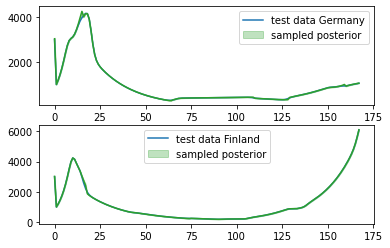

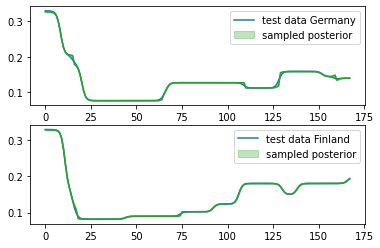

In [3]:
f, axes = plt.subplots(2)

x = np.arange(len(positive_tests))
axes[0].plot(np.array(positive_tests)[:,0], label='test data Germany')
axes[0].plot(np.median(trace.posterior['SIR_model|positive_tests'][...,0,:], axis=(0,1,3)), 
            color='tab:green')
axes[0].fill_between(x, *np.percentile(trace.posterior['SIR_model|positive_tests'][...,0,:], axis=(0,1,3), q=(2.5,97.5)), 
           label='sampled posterior', color='tab:green', alpha=0.3)
axes[0].legend()
axes[1].plot(np.array(positive_tests)[:,1], label='test data Finland')
axes[1].plot(np.median(trace.posterior['SIR_model|positive_tests'][...,1,:], axis=(0,1,3)), 
            color='tab:green')
axes[1].fill_between(x, *np.percentile(trace.posterior['SIR_model|positive_tests'][...,1,:], axis=(0,1,3), q=(2.5,97.5)), 
           label='sampled posterior', color='tab:green', alpha=0.3)

axes[1].legend()


f, axes = plt.subplots(2)
x = np.arange(len(positive_tests))
axes[0].plot(np.array(lambda_t)[:,0], label='test data Germany')
axes[0].plot(np.median(trace.posterior['SIR_model|lambda_t'][...,0,:], axis=(0,1,3)), 
            color='tab:green')
axes[0].fill_between(x, *np.percentile(trace.posterior['SIR_model|lambda_t'][...,0,:], axis=(0,1,3), q=(2.5,97.5)), 
           label='sampled posterior', color='tab:green', alpha=0.3)
axes[0].legend()
axes[1].plot(np.array(lambda_t)[:,1], label='test data Finland')
axes[1].plot(np.median(trace.posterior['SIR_model|lambda_t'][...,1,:], axis=(0,1,3)), 
            color='tab:green')
axes[1].fill_between(x, *np.percentile(trace.posterior['SIR_model|lambda_t'][...,1,:], axis=(0,1,3), q=(2.5,97.5)), 
           label='sampled posterior', color='tab:green', alpha=0.3)

axes[1].legend()


In [11]:
# the effectiveness of interventions alpha should all be around 0.38:
print(trace.posterior["SIR_model|alpha_i_c_a"])

<xarray.DataArray 'SIR_model|alpha_i_c_a' (chain: 4, draw: 750, SIR_model|alpha_i_c_a_dim_0: 5, SIR_model|alpha_i_c_a_dim_1: 2, SIR_model|alpha_i_c_a_dim_2: 1)>
array([[[[[0.3761388 ],
          [0.37976858]],

         [[0.37706962],
          [0.38070688]],

         [[0.3655762 ],
          [0.36912176]],

         [[0.38532972],
          [0.38903213]],

         [[0.38212305],
          [0.38580027]]],


        [[[0.37611187],
          [0.37969494]],

         [[0.37714213],
...
          [0.38782126]],

         [[0.38200393],
          [0.38987893]]],


        [[[0.37342504],
          [0.38111982]],

         [[0.38233843],
          [0.39018342]],

         [[0.34963256],
          [0.35691953]],

         [[0.38004825],
          [0.38785473]],

         [[0.38199684],
          [0.38983607]]]]], dtype=float32)
Coordinates:
  * chain                        (chain) int64 0 1 2 3
  * draw                         (draw) int64 0 1 2 3 4 ... 745 746 747 748 749
  * SIR_model|al

## Building a likelihood for other programs 

In [4]:
# Build likelihood function and a random initialization (from the prior)

from pymc4.mcmc.samplers import build_logp_and_deterministic_functions
(logpfn,random_init,_,_,state_,) = build_logp_and_deterministic_functions(
                                    this_model,
                                    collect_reduced_log_prob=False,)

# random_init is a dictionary with all values needed to calculate the likelihood. 
# logpfn requires the unbounded variables (as saved in random_init). 
# They can be passed either as dictionary or as list:
print(f"likelihood (of random init): {logpfn(**random_init)}")
print(f"likelihood (of random init): {logpfn(*list(random_init.values()))}")

likelihood (of random init): -7956.310546875
likelihood (of random init): -7956.310546875


### To get the number of cases and the lambda_t from a choice of parameters:


Text(0, 0.5, 'spreading rate of random initialization')

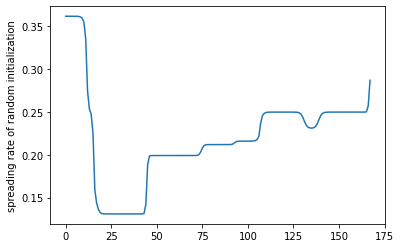

In [5]:

# Build a dummy trace, which requires extra chain and draw dimensions
dict_for_dummy_trace = {key:tf.cast(value, "float32")[tf.newaxis, tf.newaxis] 
                        for key,value in random_init.items()}
trace_tmp = az.from_dict(posterior=dict_for_dummy_trace)


variables = ["lambda_t", "positive_tests"]
model_name = "SIR_model"
var_names = []
for var in variables:
    var_names.append(f"{model_name}|{var}")

# And sample it from the model. It will use the variables saved in trace_tmp, if there is one variable
# not defined, it is randomly chosen from its distribution. 
trace_res = pm.sample_posterior_predictive(
    SIR_model(modelParams), trace_tmp, var_names=var_names, use_auto_batching=False,
)

# And plot the resulting spreading rate, it is saved in trace_res.posterior_predictive 
plt.plot(trace_res.posterior_predictive["SIR_model|lambda_t"][0,0,:,1,0])
plt.ylabel("spreading rate of random initialization")